In [24]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

# Carregamento e análise dos dados

In [14]:
# carregar arquivo csv
data = pd.read_csv('/content/drive/MyDrive/cloudwalk_test/csv/transactions_4.csv')
data.head()


,time,status,count
0,00:00,approved,9
1,00:00,denied,6
2,00:00,refunded,1
3,00:01,denied,8
4,00:01,approved,13


In [ ]:
# Verificação de valores nulos
print(data.isnull().sum())


time      0
status    0
f0_       0
dtype: int64


In [ ]:
# Verificação de valores faltantes
print(data.isna().sum())

time      0
status    0
count     0
dtype: int64


In [ ]:
# Estatísticas descritivas
print(data.describe())

             count
count  4234.000000
mean     60.148795
std     107.484684
min       1.000000
25%       2.000000
50%       9.000000
75%      52.000000
max     782.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    4234 non-null   object
 1   status  4234 non-null   object
 2   count   4234 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 99.4+ KB


In [ ]:
data.status.value_counts()

,count
status,
approved,1299
denied,1140
reversed,725
refunded,423
backend_reversed,413
processing,181
failed,53


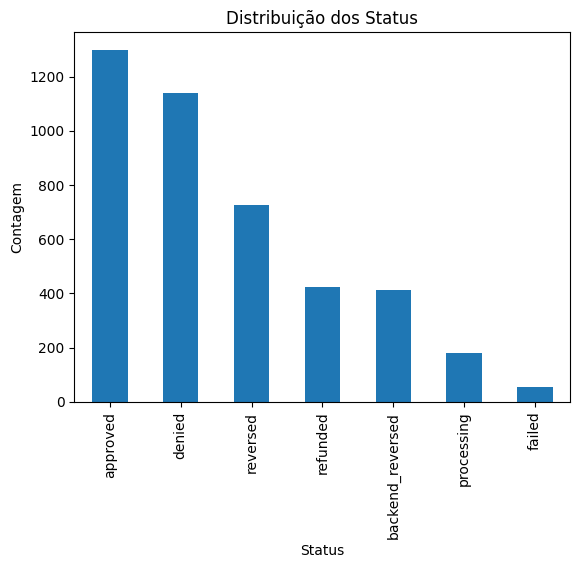

In [18]:
# Gráfico de barras para a coluna 'status'
data['status'].value_counts().plot(kind='bar')
plt.xlabel('Status')
plt.ylabel('Contagem')
plt.title('Distribuição dos Status')
plt.show()


In [15]:
data["count"].value_counts()

,count
count,
1,895
2,407
3,238
4,151
5,137
6,97
7,88
8,63
11,57


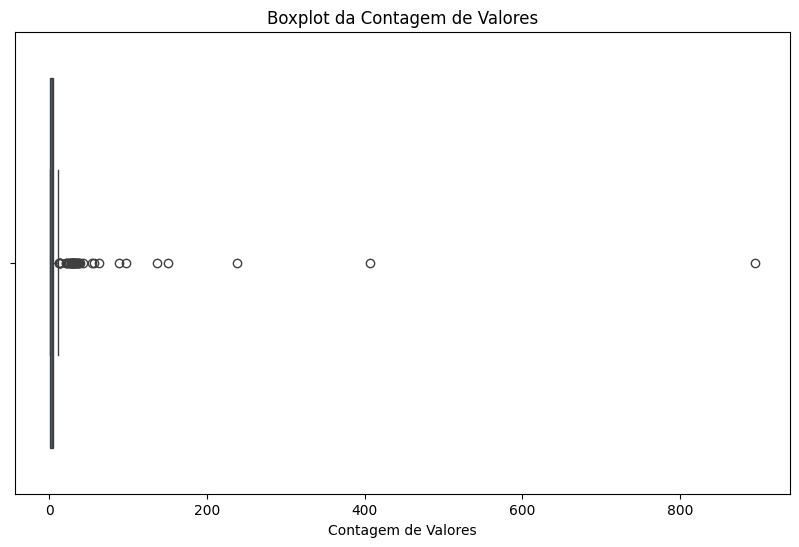

In [21]:
# Boxplot para a coluna 'count'
plt.figure(figsize=(10, 6))
sns.boxplot(x=data["count"].value_counts())
plt.xlabel('Contagem de Valores')
plt.title('Boxplot da Contagem de Valores')
plt.show()


In [16]:
# novo dataframe para modelo
df = data.copy()

In [17]:
# Convert the 'time' column to datetime objects if it contains time strings
df['time'] = pd.to_datetime(df['time'])

# Extract numerical features from the 'time' column, such as hour, minute, etc.
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

# Now you can drop the original 'time' column if you don't need it
df = df.drop('time', axis=1)

<ipython-input-17-cd6fc0cf8242>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])


In [18]:
# Definindo uma regra para identificar transações problemáticas
def detect_issues(row):
    if row['status'] in ['denied', 'failed', 'reversed']:
        return 1
    return 0

# Aplicar a regra ao DataFrame
df['Issue'] = df.apply(detect_issues, axis=1)

# Label Encode
conversão dos tipos object para numeric

In [19]:
# usar o label encode na variável status

le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])


In [185]:
df.head(20)

,status,count,hour,minute,Issue
0,0,9,0,0,0
1,2,6,0,0,1
2,5,1,0,0,0
3,2,8,0,1,1
4,0,13,0,1,0
5,5,1,0,2,0
6,0,11,0,2,0
7,2,7,0,2,1
8,2,3,0,3,1
9,0,12,0,3,0


In [20]:
# Estimativa de população anômala no dataset
contamination = 0.05

In [21]:
%%time
# Treinamento do modelo
model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
model.fit(df)

CPU times: user 204 ms, sys: 227 µs, total: 205 ms
Wall time: 205 ms


IsolationForest(contamination=0.05, random_state=42)

In [22]:
# Prever anomalias
df["Alert"] = pd.Series(model.predict(df))
df["Alert"] = df["Alert"].map({1: 0, -1: 1})
print(df["Alert"].value_counts())

Alert
0    4022
1     212
Name: count, dtype: int64


In [23]:
# testando contamination
212 / 4022

0.05271009448035803

In [159]:
# Combinar os resultados das regras e do modelo
df['final_decision'] = df.apply(lambda row: 'Alert' if row['Issue'] == 1 or row['Alert'] == 1 else 'Approve', axis=1)

# Visualizar o DataFrame final
print(df.head())

   status  count  hour  minute  Issue  Alert final_decision
0       0      9     0       0      0      0        Approve
1       2      6     0       0      1      0          Alert
2       5      1     0       0      0      1          Alert
3       2      8     0       1      1      0          Alert
4       0     13     0       1      0      0        Approve


In [160]:
# prompt: conte quantas linhas há com Approve

approved_count = df[df['final_decision'] == 'Alert'].shape[0]
print("Number of rows with 'Alert':", approved_count)


Number of rows with 'Alert': 1926


In [61]:
df.to_csv('/content/drive/MyDrive/cloudwalk_test/csv/transactions_with_decisions.csv', index=False)

In [135]:
# Salvar o modelo em um arquivo
joblib_file = "/content/drive/MyDrive/cloudwalk_test/isolation_forest_model.joblib"
joblib.dump(model, joblib_file)

print(f"Modelo salvo em {joblib_file}")

Modelo salvo em /content/drive/MyDrive/cloudwalk_test/isolation_forest_model.joblib
